In [1]:
# import functions and libraries
import numpy as np, matplotlib.pyplot as plt
from matplotlib.pyplot import *
import scipy
from scipy import signal
from numpy import *

# !sudo apt-get install libportaudio2
# !pip install sounddevice
# import sounddevice as sd

from IPython.display import Audio

# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)



!pip install ffmpeg-python
# import mic_to_np_arr as mic
!wget -O mic_to_np_arr_TEMP.py https://raw.githubusercontent.com/AbrahamSteenhoek/RaspPi_DSP/main/mic_to_np_arr.py
import mic_to_np_arr_TEMP as mic

--2021-12-17 06:43:23--  https://raw.githubusercontent.com/AbrahamSteenhoek/RaspPi_DSP/main/mic_to_np_arr.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3960 (3.9K) [text/plain]
Saving to: ‘mic_to_np_arr_TEMP.py’

mic_to_np_arr_TEMP. 100%[===================>]   3.87K  --.-KB/s    in 0s      

2021-12-17 06:43:23 (38.0 MB/s) - ‘mic_to_np_arr_TEMP.py’ saved [3960/3960]



# Helper Functions

In [2]:
def GenChirpPulseA(N, f0, f1, fs):
    # Function generates an analytic function of a chirp pulse
    # Inputs:
    #     N = pulse length in samples
    #     f0     = starting frequency of chirp
    #     f1     = end frequency of chirp
    #     fs     = sampling frequency
    # Output:
    #     pulse_a  = analytic function of chirp pulse
    
    T = N/fs
    t = np.r_[0.0:N]/fs
    k = (f1-f0)/T
    phi_of_t = 2*pi*(f0 + k/2*t)*t
    pulse_a = exp(1j*phi_of_t)
    
    return pulse_a

def GenPulseTrain( pulse_a, N_repetitions, N_segments ):
  # Function generates a pulse train from a pulse. 
  # Inputs:
  #     pulse  = the pulse generated by genChirpPulse
  #     N_repetitions   = number of pulse repetitions
  #     N_segments   = length of pulse segment >= len(pulse)
  # Output:
  #     ptrain = pulse train
  num_zeros = N_segments - len( pulse_a )
  pulse_padded = pad( pulse_a, (0,num_zeros), 'constant', constant_values=(0,0))
  return tile( pulse_padded, N_repetitions )

def ExtractChirps( mic_audio, chirp_a, chirp_train, sr ):
  t = r_[0.0:len(mic_audio)]/mic_sr
  rx_chirps = crossCorr(mic_audio, chirp_a)

  rx_chirps_abs = abs(rx_chirps)
  range = np.max(rx_chirps_abs) - np.min(rx_chirps_abs)
  thr = range/4
  first_pulse = sum(np.cumsum(rx_chirps_abs > thr)==0)

  # cut out the part of the RX signal that resembles the pulse train
  rx_chirps_trim = rx_chirps[first_pulse:first_pulse+chirp_train.size]
  t_trim = t[first_pulse:first_pulse+chirp_train.size]

  return t_trim, rx_chirps_trim

def crossCorr(rcv, pulse_a):
    # Funtion generates cross-correlation between rcv and pulse_a.
    # Inputs:
    #     rcv     = received signal
    #     pulse_a = analytic pulse
    # Output:
    #     Xrcv    = cross-correlation between rcv and pulse_a
    
    Xrcv = signal.convolve(rcv, pulse_a[::-1])
    return Xrcv

def PlotAudio( audio, sr, title_str='Audio', legend=() ):
  t = r_[0.0:len(audio[0])]/sr * 1e3
  width, height = plt.figaspect(0.2)
  fig = plt.figure(figsize=(width,height))
  for sig in audio:
    plt.plot(t, sig)
  plt.title(title_str)
  plt.xlabel('time[ms]')
  if legend:
    plt.legend(legend)
  plt.show()

def GetPulse( pulse_train, pulse_len, n=0 ):
  start_idx = n*pulse_len
  return pulse_train[start_idx:start_idx+pulse_len]

def time2dist(t, temperature=21.0):
    # Function converts time in seconds to distance in cm.
    # Inputs:
    #     t           = time in seconds between transmitted pulse and echo
    #     temperature = in Celcius
    # Output:
    #     dist        = distance to object in cm
    
    v_sound = 331.5*sqrt(1 + temperature/273.15) * 100 # in cm/s
    dist = t/2*v_sound
    
    return dist

# Sonar signal setup


*   Npulse: chirp width in samples
*   f1 - f0: BW of chirp
*   Nseg: width in between chirps in samples
*   Nrep: number of pulses to transmit



In [25]:
Npulse = 360
f0 = 1e3
f1 = 10e3
fs = 48e3
Nrep = 200
Nseg = 2400

window = signal.hann(Npulse)

pulse_a = GenChirpPulseA(Npulse, f0, f1, fs) * window
pulse = pulse_a.real
pulse_train = GenPulseTrain(pulse, Nrep, Nseg)
Audio( data=pulse_train, rate=fs )

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


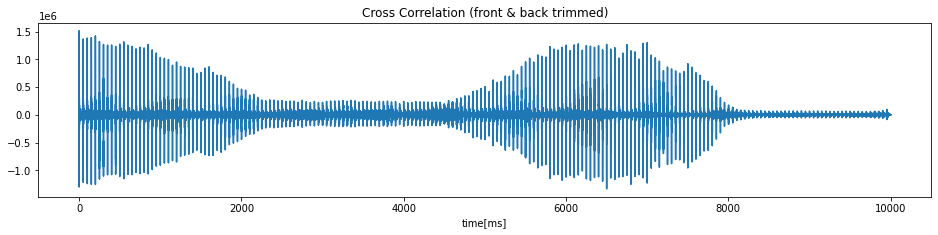

In [26]:
mic_audio, mic_sr = mic.get_audio()
# t = r_[0.0:len(mic_audio)]/mic_sr

# PlotAudio( audio=[mic_audio], sr=mic_sr, title_str='Recorded Audio (raw)' )

t, rx_chirps = ExtractChirps( mic_audio=mic_audio, chirp_a=pulse_a, chirp_train = pulse_train, sr=mic_sr )

PlotAudio( audio=[rx_chirps], sr=mic_sr, title_str='Cross Correlation (front & back trimmed)' )

Text(0, 0.5, 'Time [s]')

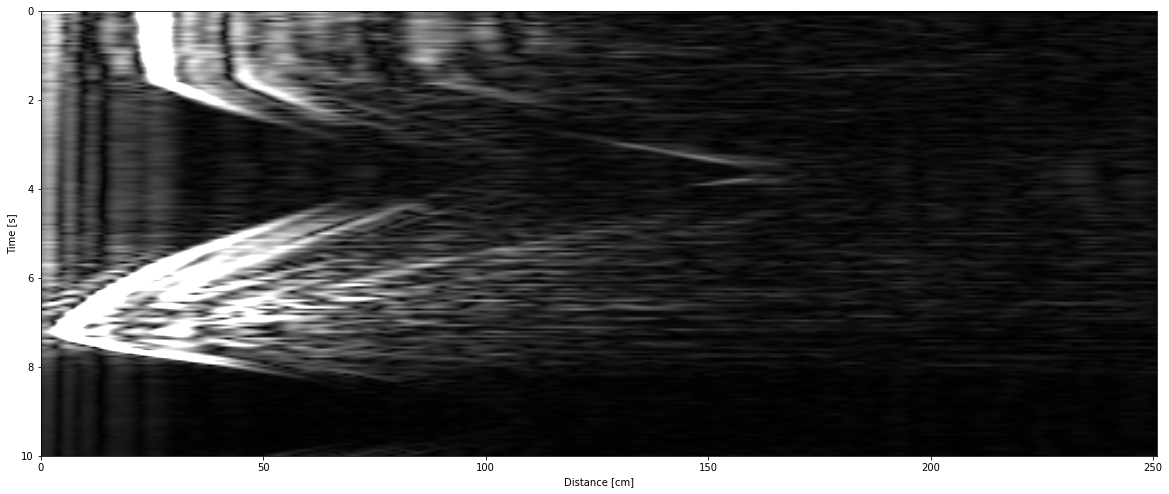

In [27]:
img = np.zeros((Nrep-1,Nseg))
rx_chirps_abs = abs(rx_chirps)
rx_chirps_abs_norm = rx_chirps_abs/max(rx_chirps_abs)

# n_list = np.arange(Nrep-1)


for k in range(Nrep-1):
  pulse_k = GetPulse( pulse_train=rx_chirps_abs_norm, pulse_len=Nseg, n=k )
  img[k,:]= pulse_k


vmax = 0.25
dist_display_range = 700
fig = figure( figsize=(20,40) )
plt.imshow(img[:,0:dist_display_range]/max(img.ravel()), vmax=vmax, aspect=10, cmap='gray', interpolation='bilinear', extent=(0,time2dist(dist_display_range/fs), Nrep*Nseg/fs, 0))
plt.xlabel('Distance [cm]')
plt.ylabel('Time [s]')